In [ ]:
!git clone https://github.com/5hyfilm/2110433-cv-project

fatal: destination path '2110433-cv-project' already exists and is not an empty directory.


In [ ]:
# ================================
# 📦 Imports & Environment Setup
# ================================

!pip install transformers -q

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from transformers import ViTModel, ViTFeatureExtractor

# ✅ Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)                # สำหรับ GPU
    torch.backends.cudnn.deterministic = True   # ทำให้ deterministic
    torch.backends.cudnn.benchmark = False      # ปิด optimization ที่ไม่ repeatable

set_seed(42)  # ✅ เรียกใช้ตรงนี้

In [ ]:
# ================================
# 🖼️ ViT Encoder Module
# ================================

class ViTImageEncoder(nn.Module):
    def __init__(self, model_name='google/vit-base-patch16-224-in21k'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.hidden_size = self.vit.config.hidden_size  # Usually 768

    def forward(self, x):
        # x shape: [B, 3, 224, 224]
        outputs = self.vit(pixel_values=x)
        return outputs.last_hidden_state  # shape: [B, num_patches+1, 768]

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# ================================
# 🧾 Metadata MLP Encoder
# ================================

class MetadataEncoder(nn.Module):
    def __init__(self, input_dim=3, embed_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim),
            nn.ReLU()
        )

    def forward(self, x):
        # x: [B, 3]  → age (normalized), sex (encoded), location (encoded)
        x = self.encoder(x)       # shape: [B, 128]
        x = x.unsqueeze(1)        # shape: [B, 1, 128] → เพื่อใช้เป็น token
        return x

In [ ]:
# ================================
# 🔁 Cross-Attention Block
# ================================

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim_q=768, dim_kv=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim_q // num_heads) ** -0.5

        self.q_proj = nn.Linear(dim_q, dim_q)
        self.k_proj = nn.Linear(dim_kv, dim_q)
        self.v_proj = nn.Linear(dim_kv, dim_q)
        self.out_proj = nn.Linear(dim_q, dim_q)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, context):
        # query: [B, Lq, Dq]     ← image tokens from ViT
        # context: [B, Lk, Dkv]  ← metadata tokens from MLP

        B, Lq, Dq = query.size()
        Lk = context.size(1)

        Q = self.q_proj(query).view(B, Lq, self.num_heads, -1).transpose(1, 2)  # [B, H, Lq, Dh]
        K = self.k_proj(context).view(B, Lk, self.num_heads, -1).transpose(1, 2)  # [B, H, Lk, Dh]
        V = self.v_proj(context).view(B, Lk, self.num_heads, -1).transpose(1, 2)  # [B, H, Lk, Dh]

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # [B, H, Lq, Lk]
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        attn_output = torch.matmul(attn_probs, V)  # [B, H, Lq, Dh]
        attn_output = attn_output.transpose(1, 2).reshape(B, Lq, Dq)

        return self.out_proj(attn_output)  # [B, Lq, Dq]

In [ ]:
# ================================
# 🧠 Multimodal ViT with Cross-Attention
# ================================

class MultimodalViTWithCrossAttention(nn.Module):
    def __init__(self, image_model_name='google/vit-base-patch16-224-in21k',
                 meta_input_dim=3, meta_embed_dim=128, num_classes=7):
        super().__init__()

        # 🖼️ Image encoder
        self.image_encoder = ViTImageEncoder(model_name=image_model_name)

        # 🧾 Metadata encoder
        self.meta_encoder = MetadataEncoder(input_dim=meta_input_dim, embed_dim=meta_embed_dim)

        # 🔁 Cross-Attention
        self.cross_attention = CrossAttentionBlock(
            dim_q=self.image_encoder.hidden_size,  # 768
            dim_kv=meta_embed_dim,                 # 128
            num_heads=4
        )

        # 🔽 Classifier (ใช้ CLS token ที่ fused แล้ว)
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.image_encoder.hidden_size),
            nn.Linear(self.image_encoder.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, metadata):
        # 1. Encode image → [B, 197, 768]
        image_tokens = self.image_encoder(images)

        # 2. Encode metadata → [B, 1, 128]
        meta_tokens = self.meta_encoder(metadata)

        # 3. Fuse with Cross-Attention → [B, 197, 768]
        fused_tokens = self.cross_attention(image_tokens, meta_tokens)

        # 4. Use CLS token (position 0) → [B, 768]
        cls_token = fused_tokens[:, 0, :]

        # 5. Classify
        out = self.classifier(cls_token)
        return out

In [ ]:
# ================================
# 📊 HAM10000 Dataset Loader
# ================================

class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, img_dir, transform, sex_encoder, loc_encoder):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.sex_encoder = sex_encoder
        self.loc_encoder = loc_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'] + '.jpg')
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # ➕ Metadata preprocessing
        age = row['age'] if not pd.isna(row['age']) else 50
        sex = self.sex_encoder.transform([row['sex']])[0] if pd.notna(row['sex']) else 0
        loc = self.loc_encoder.transform([row['localization']])[0] if pd.notna(row['localization']) else 0

        meta = torch.tensor([age / 100.0, sex, loc / 10.0], dtype=torch.float32)

        label = torch.tensor(row['label'], dtype=torch.long)

        return image, meta, label

In [ ]:
# 🧾 Load metadata CSV
df = pd.read_csv('2110433-cv-project/HAM10000_balanced/train/HAM10000_train.csv')

# ➕ Encode label
df['label'] = LabelEncoder().fit_transform(df['dx'])

# ➕ Encode sex / localization
sex_encoder = LabelEncoder().fit(df['sex'].dropna().unique())
loc_encoder = LabelEncoder().fit(df['localization'].dropna().unique())

# 📊 Train / Val split
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
test_df = pd.read_csv('2110433-cv-project/HAM10000_balanced/test/HAM10000_test.csv')
test_df['label'] = LabelEncoder().fit(df['dx']).transform(test_df['dx'])

In [ ]:
train_image_dir = '2110433-cv-project/HAM10000_balanced/train/train_images'
test_image_dir = '2110433-cv-project/HAM10000_balanced/test/test_images'

train_dataset = HAM10000Dataset(train_df, train_image_dir, img_transform, sex_encoder, loc_encoder)
val_dataset = HAM10000Dataset(val_df, train_image_dir, img_transform, sex_encoder, loc_encoder)
test_dataset = HAM10000Dataset(test_df, test_image_dir, img_transform, sex_encoder, loc_encoder)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# ================================
# 🏋️ Train / Validate Function
# ================================

from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0

    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, metadata, labels in loop:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

        # ✅ อัปเดต tqdm bar
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_correct / len(dataloader.dataset)
    return avg_loss, avg_acc

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    loop = tqdm(dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for images, metadata, labels in loop:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()

            # ✅ อัปเดต tqdm
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_correct / len(dataloader.dataset)
    return avg_loss, avg_acc

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import numpy as np

# 🧾 คำนวณ class weights จาก training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
# ================================
# 🚀 Training Setup
# ================================

model = MultimodalViTWithCrossAttention().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0  # 👈 สำหรับเก็บค่าสูงสุดที่เคยได้

num_epochs = 30

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    # บันทึกค่า
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # เช็คและ save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved best model at epoch {epoch+1} with val acc: {val_acc:.4f}")

    # แสดงผล
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}\n")

✅ Saved best model at epoch 1 with val acc: 0.2298
Epoch 1/30
Train Loss: 1.9192 | Train Acc: 0.1839
Val   Loss: 1.8096 | Val   Acc: 0.2298



Epoch 2/30
Train Loss: 1.8248 | Train Acc: 0.2159
Val   Loss: 1.7813 | Val   Acc: 0.2136



✅ Saved best model at epoch 3 with val acc: 0.2718
Epoch 3/30
Train Loss: 1.7955 | Train Acc: 0.2141
Val   Loss: 1.7490 | Val   Acc: 0.2718



Epoch 4/30
Train Loss: 1.7755 | Train Acc: 0.2159
Val   Loss: 1.7357 | Val   Acc: 0.1942



✅ Saved best model at epoch 5 with val acc: 0.3010
Epoch 5/30
Train Loss: 1.7648 | Train Acc: 0.2314
Val   Loss: 1.7282 | Val   Acc: 0.3010



Epoch 6/30
Train Loss: 1.7438 | Train Acc: 0.2451
Val   Loss: 1.7107 | Val   Acc: 0.2362



Epoch 7/30
Train Loss: 1.7255 | Train Acc: 0.2321
Val   Loss: 1.7456 | Val   Acc: 0.2330



Epoch 8/30
Train Loss: 1.7219 | Train Acc: 0.2350
Val   Loss: 1.7315 | Val   Acc: 0.2686



Epoch 9/30
Train Loss: 1.7221 | Train Acc: 0.2353
Val   Loss: 1.7454 | Val   Acc: 0.2104



Epoch 10/30
Train Loss: 1.7164 | Train Acc: 0.2425
Val   Loss: 1.7307 | Val   Acc: 0.1715



Epoch 11/30
Train Loss: 1.7088 | Train Acc: 0.2451
Val   Loss: 1.7165 | Val   Acc: 0.2783



✅ Saved best model at epoch 12 with val acc: 0.3139
Epoch 12/30
Train Loss: 1.6896 | Train Acc: 0.2389
Val   Loss: 1.6893 | Val   Acc: 0.3139



Epoch 13/30
Train Loss: 1.6996 | Train Acc: 0.2454
Val   Loss: 1.7308 | Val   Acc: 0.2362



Epoch 14/30
Train Loss: 1.6932 | Train Acc: 0.2443
Val   Loss: 1.7477 | Val   Acc: 0.2880



Epoch 15/30
Train Loss: 1.6881 | Train Acc: 0.2504
Val   Loss: 1.7026 | Val   Acc: 0.2848



Epoch 16/30
Train Loss: 1.6803 | Train Acc: 0.2483
Val   Loss: 1.6944 | Val   Acc: 0.3010



Epoch 17/30
Train Loss: 1.6777 | Train Acc: 0.2555
Val   Loss: 1.7137 | Val   Acc: 0.2880



Epoch 18/30
Train Loss: 1.6775 | Train Acc: 0.2594
Val   Loss: 1.7046 | Val   Acc: 0.3042



Epoch 19/30
Train Loss: 1.6632 | Train Acc: 0.2472
Val   Loss: 1.6915 | Val   Acc: 0.2427



Epoch 20/30
Train Loss: 1.6560 | Train Acc: 0.2558
Val   Loss: 1.6856 | Val   Acc: 0.3010



Epoch 21/30
Train Loss: 1.6645 | Train Acc: 0.2778
Val   Loss: 1.7078 | Val   Acc: 0.2233



Epoch 22/30
Train Loss: 1.6599 | Train Acc: 0.2512
Val   Loss: 1.6584 | Val   Acc: 0.3107



Epoch 23/30
Train Loss: 1.6524 | Train Acc: 0.2630
Val   Loss: 1.6852 | Val   Acc: 0.2557



Epoch 24/30
Train Loss: 1.6485 | Train Acc: 0.2778
Val   Loss: 1.6635 | Val   Acc: 0.2654



Epoch 25/30
Train Loss: 1.6350 | Train Acc: 0.2501
Val   Loss: 1.6742 | Val   Acc: 0.2848



Epoch 26/30
Train Loss: 1.6360 | Train Acc: 0.2717
Val   Loss: 1.6832 | Val   Acc: 0.2718



Epoch 27/30
Train Loss: 1.6267 | Train Acc: 0.2515
Val   Loss: 1.6915 | Val   Acc: 0.2816



Epoch 28/30
Train Loss: 1.6358 | Train Acc: 0.2652
Val   Loss: 1.6517 | Val   Acc: 0.2816



Epoch 29/30
Train Loss: 1.6289 | Train Acc: 0.2810
Val   Loss: 1.6524 | Val   Acc: 0.2718



Epoch 30/30
Train Loss: 1.6287 | Train Acc: 0.2630
Val   Loss: 1.6689 | Val   Acc: 0.2686



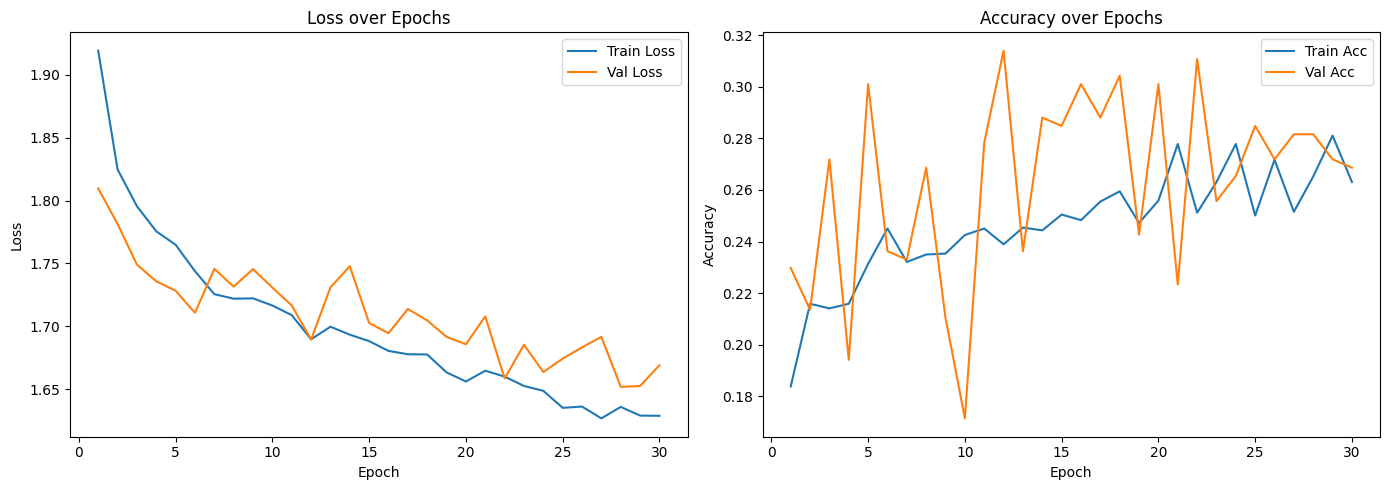

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

# 🔷 Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 🔶 Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def get_all_preds(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images, metadata = images.to(device), metadata.to(device)
            outputs = model(images, metadata)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [ ]:
# ✅ โหลดโมเดลที่ val accuracy ดีที่สุด
model = MultimodalViTWithCrossAttention().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_pred, y_true = get_all_preds(model, val_loader)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])  # ค่า 0–6 สำหรับ 7 class

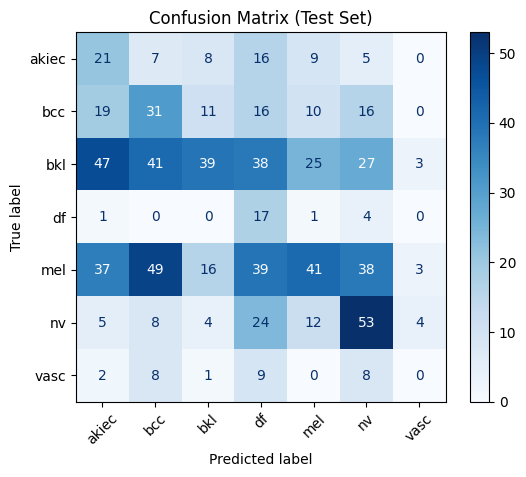

📋 Classification Report:

              precision    recall  f1-score   support

       akiec       0.16      0.32      0.21        66
         bcc       0.22      0.30      0.25       103
         bkl       0.49      0.18      0.26       220
          df       0.11      0.74      0.19        23
         mel       0.42      0.18      0.26       223
          nv       0.35      0.48      0.41       110
        vasc       0.00      0.00      0.00        28

    accuracy                           0.26       773
   macro avg       0.25      0.31      0.22       773
weighted avg       0.36      0.26      0.26       773



In [ ]:
# 🔁 Function: get predictions
def get_all_preds(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images = images.to(device)
            metadata = metadata.to(device)
            outputs = model(images, metadata)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# 🧪 Get predictions and true labels
y_pred, y_true = get_all_preds(model, test_loader)

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.show()

# 📋 Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

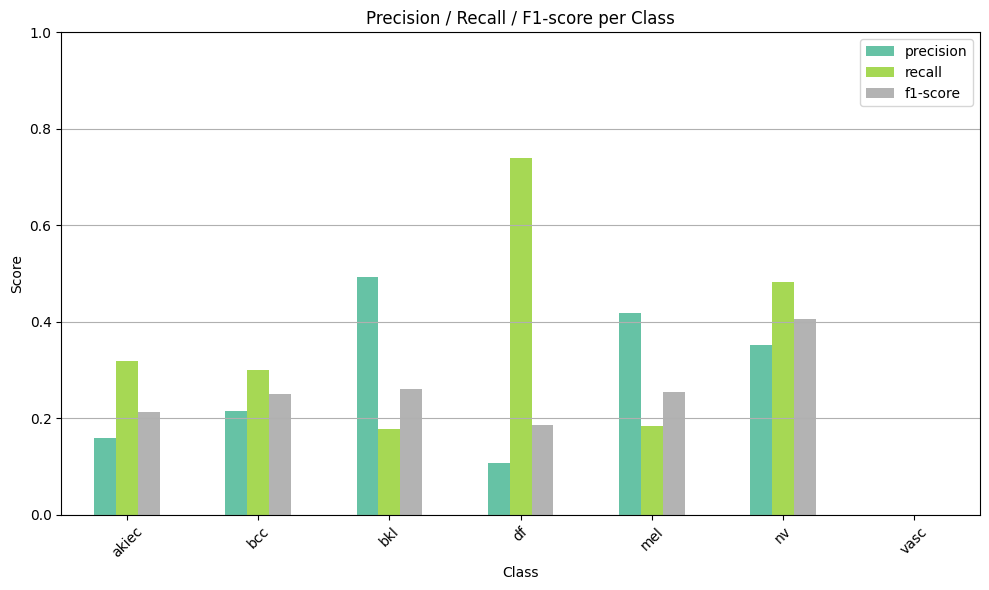

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# 🎯 Get report as dictionary
report_dict = classification_report(
    y_true, y_pred,
    target_names=label_encoder.classes_,
    output_dict=True  # <– สำคัญ! เพื่อให้แปลงเป็น DataFrame ได้
)

# 🧾 แปลงเป็น DataFrame (เอาเฉพาะ class จริงๆ ตัด 'accuracy', 'macro avg' ออก)
df_report = pd.DataFrame(report_dict).T
df_report = df_report.iloc[:-3]  # ตัด accuracy, macro avg, weighted avg ออก

# 🎨 วาด bar chart
df_report[['precision', 'recall', 'f1-score']].plot(
    kind='bar',
    figsize=(10, 6),
    ylim=(0, 1),
    colormap='Set2'
)

plt.title('Precision / Recall / F1-score per Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_gradcam(model, image_tensor, metadata_tensor, target_class=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    metadata_tensor = metadata_tensor.unsqueeze(0).to(device)

    # Hook เก็บ gradient ของ CLS token
    grads = {}

    def hook_fn(grad):
        grads['cls_grad'] = grad

    # Forward เพื่อให้ได้ CLS token (หลัง cross-attention)
    with torch.enable_grad():
        image_tensor.requires_grad_()

        fused_tokens = model.cross_attention(
            model.image_encoder(image_tensor),
            model.meta_encoder(metadata_tensor)
        )
        cls_token = fused_tokens[:, 0, :]  # [B, 768]
        cls_token.retain_grad()
        cls_token.register_hook(hook_fn)

        # Forward เข้าคลาสสิฟาย
        output = model.classifier(cls_token)
        pred_class = output.argmax(dim=1).item()

        # ถ้าไม่ระบุ target_class → ใช้ค่าที่โมเดลทำนาย
        if target_class is None:
            target_class = pred_class

        loss = output[0, target_class]
        loss.backward()

        grad = grads['cls_grad'][0].cpu().detach().numpy()  # [768]
        heatmap = np.abs(grad)
        heatmap = heatmap / np.max(heatmap)  # Normalize

    return heatmap, pred_class

In [ ]:
def show_gradcam_on_image(img_tensor, heatmap, alpha=0.5):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize image

    # Resize heatmap (ไม่มี spatial map → reshape แบบ simple)
    heatmap_resized = cv2.resize(heatmap.reshape(24, 32), (224, 224))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = np.float32(heatmap_color) / 255

    overlay = heatmap_color * alpha + img
    overlay = overlay / overlay.max()

    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM Overlay")
    plt.show()

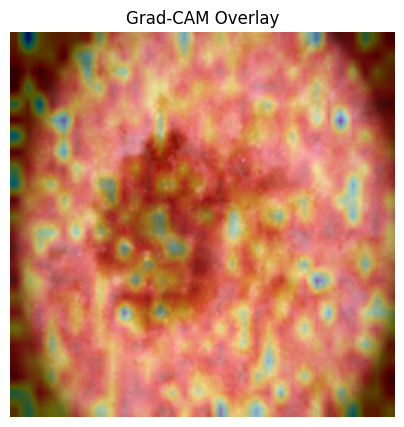

Predicted Class: akiec


In [ ]:
# เลือก sample จาก validation set
image, metadata, label = val_dataset[0]

# สร้าง heatmap
heatmap, pred_class = generate_gradcam(model, image, metadata)

# แสดง overlay
show_gradcam_on_image(image, heatmap)
print(f"Predicted Class: {label_encoder.classes_[pred_class]}")

# Start Model Training

In [ ]:
# ================================
# 📦 Imports & Environment Setup
# ================================
# !git clone https://github.com/5hyfilm/2110433-cv-project # Clone repo if needed

!pip install transformers datasets scikit-learn pandas torch torchvision tqdm -q

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # <--- เพิ่ม OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import ViTModel, ViTImageExtractor # <--- เปลี่ยน ViTFeatureExtractor เป็น ViTImageExtractor (ชื่อใหม่กว่า)
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch.optim.lr_scheduler as lr_scheduler # <--- เพิ่ม Scheduler

# ✅ Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Set Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if using multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# ================================
#  EDA (Optional - can be skipped if data is already explored)
# ================================
# Code for EDA from the original notebook can be placed here if needed
# print("Skipping EDA for brevity...")

# ================================
# 🖼️ ViT Encoder Module
# ================================
class ViTImageEncoder(nn.Module):
    def __init__(self, model_name='google/vit-base-patch16-224-in21k'):
        super().__init__()
        # Load ViT model - freeze its parameters initially if desired (fine-tuning later)
        self.vit = ViTModel.from_pretrained(model_name)
        self.hidden_size = self.vit.config.hidden_size # Usually 768
        # Example: Freeze ViT layers initially
        # for param in self.vit.parameters():
        #     param.requires_grad = False

    def forward(self, x):
        # x shape: [B, 3, 224, 224]
        outputs = self.vit(pixel_values=x)
        # Return the CLS token representation and possibly patch tokens
        return outputs.last_hidden_state # shape: [B, num_patches+1, 768]

# Use ViTImageExtractor for preprocessing
image_extractor = ViTImageExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
img_transform = transforms.Compose([
    transforms.Resize((image_extractor.size['height'], image_extractor.size['width'])), # Use size from extractor
    transforms.ToTensor(),
    transforms.Normalize(mean=image_extractor.image_mean, std=image_extractor.image_std)
])

# ================================
# 🧾 Metadata MLP Encoder (Revised for One-Hot)
# ================================
class MetadataEncoder(nn.Module):
    # input_dim will now be 1 (age) + num_sex_cats + num_loc_cats
    def __init__(self, input_dim, embed_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64), # <--- Add BatchNorm
            nn.ReLU(),
            nn.Dropout(0.2),    # <--- Add Dropout
            nn.Linear(64, embed_dim),
            # nn.BatchNorm1d(embed_dim), # Optional BatchNorm here
            nn.ReLU()
        )
        self.output_dim = embed_dim # Store output dimension

    def forward(self, x):
        # x: [B, input_dim] -> age (normalized) + sex (one-hot) + location (one-hot)
        x = self.encoder(x)       # shape: [B, embed_dim]
        x = x.unsqueeze(1)        # shape: [B, 1, embed_dim] -> To act as a single token
        return x

# ================================
# 🔁 Cross-Attention Block
# ================================
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim_q=768, dim_kv=128, num_heads=8, dropout=0.1): # <--- Increased num_heads
        super().__init__()
        assert dim_q % num_heads == 0, "dim_q must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = dim_q // num_heads
        self.scale = self.head_dim ** -0.5

        self.q_proj = nn.Linear(dim_q, dim_q)
        self.k_proj = nn.Linear(dim_kv, dim_q) # Project context to query dim
        self.v_proj = nn.Linear(dim_kv, dim_q) # Project context to query dim
        self.out_proj = nn.Linear(dim_q, dim_q)
        self.dropout = nn.Dropout(dropout)
        self.norm_q = nn.LayerNorm(dim_q) # <--- Add LayerNorm
        self.norm_kv = nn.LayerNorm(dim_kv) # <--- Add LayerNorm

    def forward(self, query, context):
        # query: [B, Lq, Dq]     <- image tokens from ViT (e.g., [B, 197, 768])
        # context: [B, Lk, Dkv]  <- metadata token(s) from MLP (e.g., [B, 1, 128])

        B, Lq, Dq = query.size()
        Lk, Dkv = context.size(1), context.size(2)

        # Apply LayerNorm
        query = self.norm_q(query)
        context = self.norm_kv(context)

        # Project Q, K, V
        Q = self.q_proj(query).view(B, Lq, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, Lq, Dh]
        K = self.k_proj(context).view(B, Lk, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, Lk, Dh]
        V = self.v_proj(context).view(B, Lk, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, Lk, Dh]

        # Scaled Dot-Product Attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # [B, H, Lq, Lk]
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # Apply attention to V
        attn_output = torch.matmul(attn_probs, V)  # [B, H, Lq, Dh]

        # Reshape and project output
        attn_output = attn_output.transpose(1, 2).reshape(B, Lq, Dq)
        output = self.out_proj(attn_output) # [B, Lq, Dq]

        return output

# ================================
# 🧠 Multimodal ViT with Cross-Attention (Revised)
# ================================
class MultimodalViTWithCrossAttention(nn.Module):
    def __init__(self, image_model_name='google/vit-base-patch16-224-in21k',
                 meta_input_dim=None, # Will be calculated later
                 meta_embed_dim=128,
                 num_classes=7,
                 num_attn_heads=8, # Match CrossAttentionBlock
                 dropout_rate=0.3): # Classifier dropout
        super().__init__()
        assert meta_input_dim is not None, "meta_input_dim must be provided"

        # 🖼️ Image encoder
        self.image_encoder = ViTImageEncoder(model_name=image_model_name)
        vit_hidden_size = self.image_encoder.hidden_size

        # 🧾 Metadata encoder
        self.meta_encoder = MetadataEncoder(input_dim=meta_input_dim, embed_dim=meta_embed_dim)

        # 🔁 Cross-Attention
        # Option 1: Image queries Metadata (as in original code)
        self.cross_attention = CrossAttentionBlock(
            dim_q=vit_hidden_size,      # Image token dim
            dim_kv=meta_embed_dim,      # Metadata token dim
            num_heads=num_attn_heads
        )
        # Option 2: Metadata queries Image (Alternative - might require different handling of CLS token)
        # self.cross_attention_meta_q = CrossAttentionBlock(...)

        # Add LayerNorm before classifier
        self.norm_final = nn.LayerNorm(vit_hidden_size)

        # 🔽 Classifier (using CLS token after potential fusion)
        self.classifier = nn.Sequential(
            # LayerNorm is now applied before this
            nn.Linear(vit_hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, metadata):
        # 1. Encode image -> [B, 197, 768]
        image_tokens = self.image_encoder(images) # Includes CLS token at index 0

        # 2. Encode metadata -> [B, 1, meta_embed_dim]
        meta_tokens = self.meta_encoder(metadata)

        # 3. Fuse with Cross-Attention (Image queries Metadata)
        # Apply attention, result has same shape as query [B, 197, 768]
        attn_output = self.cross_attention(image_tokens, meta_tokens)

        # 4. Add result back to original image tokens (Residual Connection)
        fused_tokens = image_tokens + attn_output # <--- Add residual connection

        # 5. Use the potentially updated CLS token (position 0) -> [B, 768]
        cls_token = fused_tokens[:, 0, :]

        # 6. Apply final LayerNorm
        cls_token_norm = self.norm_final(cls_token)

        # 7. Classify
        out = self.classifier(cls_token_norm)
        return out

# ================================
# 📊 HAM10000 Dataset Loader (Revised for One-Hot)
# ================================
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, img_dir, transform, label_encoder_dx, ohe_sex, ohe_loc, age_mean, age_std):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.label_encoder_dx = label_encoder_dx
        self.ohe_sex = ohe_sex
        self.ohe_loc = ohe_loc
        self.age_mean = age_mean
        self.age_std = age_std
        # Handle potential NaN in 'dx' if it exists before encoding
        self.df['dx'] = self.df['dx'].fillna('unknown_dx') # Or handle appropriately
        self.df['label'] = self.label_encoder_dx.transform(self.df['dx'])


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['image_id']
        img_path = os.path.join(self.img_dir, img_id + '.jpg')

        try:
            image = Image.open(img_path).convert("RGB")
            image = self.transform(image)
        except FileNotFoundError:
            print(f"Warning: Image not found {img_path}. Returning dummy data.")
            # Return dummy data or handle appropriately
            image = torch.zeros((3, image_extractor.size['height'], image_extractor.size['width']))
            # Ensure other return values match expected types
            meta = torch.zeros(1 + len(self.ohe_sex.categories_[0]) + len(self.ohe_loc.categories_[0])) # Calculate correct dim
            label = torch.tensor(-1, dtype=torch.long) # Indicate error
            return image, meta, label


        # --- Metadata Preprocessing (One-Hot) ---
        # Age: Fill NaN with mean, then normalize (using train set mean/std)
        age = row['age'] if pd.notna(row['age']) else self.age_mean
        normalized_age = (age - self.age_mean) / (self.age_std + 1e-6) # Add epsilon for safety

        # Sex: Fill NaN, then One-Hot Encode
        sex = row['sex'] if pd.notna(row['sex']) else 'unknown' # Use consistent fill value
        sex_onehot = self.ohe_sex.transform([[sex]]).toarray().flatten()

        # Location: Fill NaN, then One-Hot Encode
        loc = row['localization'] if pd.notna(row['localization']) else 'unknown' # Use consistent fill value
        loc_onehot = self.ohe_loc.transform([[loc]]).toarray().flatten()

        # Combine metadata features
        meta_features = np.concatenate(([normalized_age], sex_onehot, loc_onehot))
        meta = torch.tensor(meta_features, dtype=torch.float32)
        # --- End Metadata Preprocessing ---

        label = torch.tensor(row['label'], dtype=torch.long)

        return image, meta, label

# ================================
# 💾 Data Loading and Preparation (Using Balanced Data)
# ================================

# Define paths to balanced data
train_csv_path = '2110433-cv-project/HAM10000_balanced/train/HAM10000_train.csv'
test_csv_path = '2110433-cv-project/HAM10000_balanced/test/HAM10000_test.csv'
train_image_dir = '2110433-cv-project/HAM10000_balanced/train/train_images'
test_image_dir = '2110433-cv-project/HAM10000_balanced/test/test_images'

# Check if files exist
if not os.path.exists(train_csv_path) or not os.path.exists(test_csv_path):
    raise FileNotFoundError("Balanced dataset CSV files not found. Please ensure they are in the correct path.")
if not os.path.exists(train_image_dir) or not os.path.exists(test_image_dir):
     raise FileNotFoundError("Balanced dataset image directories not found.")


# Load DataFrames
df_train_full = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

# --- Preprocessing Steps ---
# 1. Handle NaNs consistently before encoding
df_train_full['age'] = df_train_full['age'].fillna(df_train_full['age'].mean())
df_train_full['sex'] = df_train_full['sex'].fillna('unknown')
df_train_full['localization'] = df_train_full['localization'].fillna('unknown')

df_test['age'] = df_test['age'].fillna(df_train_full['age'].mean()) # Use train mean for test
df_test['sex'] = df_test['sex'].fillna('unknown')
df_test['localization'] = df_test['localization'].fillna('unknown')

# 2. Fit Label Encoders and OneHotEncoders *only* on Training Data
label_encoder_dx = LabelEncoder()
df_train_full['label'] = label_encoder_dx.fit_transform(df_train_full['dx'])
num_classes = len(label_encoder_dx.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder_dx.classes_}")

# Ensure test set labels are transformed using the *same* encoder
# Add handling for classes potentially missing in test set if necessary
test_labels = df_test['dx'].unique()
known_labels = label_encoder_dx.classes_
df_test = df_test[df_test['dx'].isin(known_labels)] # Keep only known labels
df_test['label'] = label_encoder_dx.transform(df_test['dx'])


# Fit OneHotEncoders for Sex and Location on Training Data
ohe_sex = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # Use sparse_output=False
ohe_sex.fit(df_train_full[['sex']])
num_sex_categories = len(ohe_sex.categories_[0])
print(f"Sex categories: {ohe_sex.categories_[0]}")


ohe_loc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_loc.fit(df_train_full[['localization']])
num_loc_categories = len(ohe_loc.categories_[0])
print(f"Location categories ({num_loc_categories}): {ohe_loc.categories_[0]}")


# Calculate Age Mean/Std from Training Data for normalization
age_mean = df_train_full['age'].mean()
age_std = df_train_full['age'].std()

# Calculate Metadata Input Dimension for the MLP
meta_input_dim_onehot = 1 + num_sex_categories + num_loc_categories # 1 for age
print(f"Calculated Metadata Input Dimension: {meta_input_dim_onehot}")

# 3. Split Training Data into Train and Validation Sets
df_train, df_val = train_test_split(df_train_full, test_size=0.15, stratify=df_train_full['label'], random_state=42) # Increased val size slightly
print(f"Train samples: {len(df_train)}, Validation samples: {len(df_val)}, Test samples: {len(df_test)}")


# 4. Create Datasets and DataLoaders
train_dataset = HAM10000Dataset(df_train, train_image_dir, img_transform, label_encoder_dx, ohe_sex, ohe_loc, age_mean, age_std)
val_dataset = HAM10000Dataset(df_val, train_image_dir, img_transform, label_encoder_dx, ohe_sex, ohe_loc, age_mean, age_std)
test_dataset = HAM10000Dataset(df_test, test_image_dir, img_transform, label_encoder_dx, ohe_sex, ohe_loc, age_mean, age_std)

# Adjust batch size if memory issues occur
BATCH_SIZE = 16 # Or 8, 32 depending on GPU memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# ================================
# 🏋️ Train / Validate Functions (Minor updates for tqdm)
# ================================
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct = 0, 0
    num_samples = 0

    loop = tqdm(dataloader, desc="Training", leave=True) # Keep loop visible
    for images, metadata, labels in loop:
        # Skip dummy data if image wasn't found
        if torch.all(labels == -1):
            continue

        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)

        # Gradient clipping (optional but can help stabilize training)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        num_samples += batch_size

        loop.set_postfix(loss=loss.item(), acc=f"{(preds == labels).sum().item()/batch_size:.3f}")

    avg_loss = total_loss / num_samples if num_samples > 0 else 0
    avg_acc = total_correct / num_samples if num_samples > 0 else 0
    return avg_loss, avg_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    num_samples = 0

    loop = tqdm(dataloader, desc="Validating", leave=True) # Keep loop visible
    with torch.no_grad():
        for images, metadata, labels in loop:
            if torch.all(labels == -1):
                continue

            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            num_samples += batch_size

            loop.set_postfix(loss=loss.item(), acc=f"{(preds == labels).sum().item()/batch_size:.3f}")

    avg_loss = total_loss / num_samples if num_samples > 0 else 0
    avg_acc = total_correct / num_samples if num_samples > 0 else 0
    return avg_loss, avg_acc

# ================================
# 🚀 Training Setup (Revised)
# ================================

# Calculate class weights from the *actual training split*
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['label']),
    y=df_train['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

# Instantiate the model with the calculated metadata input dimension
model = MultimodalViTWithCrossAttention(
    meta_input_dim=meta_input_dim_onehot,
    num_classes=num_classes,
    num_attn_heads=8, # Example, can be tuned
    dropout_rate=0.4 # Slightly increased dropout
).to(device)

# Optimizer: AdamW with weight decay
LEARNING_RATE = 3e-5 # <--- Lower initial LR often better for fine-tuning ViT
WEIGHT_DECAY = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Loss Function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Learning Rate Scheduler
NUM_EPOCHS = 50 # <--- Increased number of epochs
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-7) # Cosine schedule

# ================================
# ✨ Training Loop (Revised)
# ================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0
best_epoch = 0

print("\nStarting Training...")
for epoch in range(NUM_EPOCHS):
    print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Step the scheduler
    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr'] # Get current learning rate

    print(f"Epoch {epoch+1} Summary:")
    print(f"  LR: {current_lr:.7f}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Save the model with the best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_cross_attention_model.pth")
        print(f"  ✨ New best model saved! Val Acc: {val_acc:.4f} at epoch {best_epoch}")
    print("-" * 20)

print(f"\nTraining finished. Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")


# ================================
# 📈 Plotting Results
# ================================
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# ================================
# 🧪 Final Evaluation on Test Set
# ================================

print("\nEvaluating on Test Set using the best model...")

# Load the best model saved during training
best_model = MultimodalViTWithCrossAttention(
    meta_input_dim=meta_input_dim_onehot,
    num_classes=num_classes
).to(device)
try:
    best_model.load_state_dict(torch.load("best_cross_attention_model.pth"))
    best_model.eval()

    # Function to get predictions (can reuse from original code if needed)
    def get_all_preds(model, dataloader, device):
        model.eval()
        all_preds = []
        all_labels = []
        loop = tqdm(dataloader, desc="Predicting", leave=False)
        with torch.no_grad():
            for images, metadata, labels in loop:
                if torch.all(labels == -1):
                    continue
                images, metadata = images.to(device), metadata.to(device)
                outputs = model(images, metadata)
                preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())
        return np.array(all_preds), np.array(all_labels)

    # Get predictions on the TEST set
    y_pred_test, y_true_test = get_all_preds(best_model, test_loader, device)

    # --- Display Metrics ---
    print("\n📋 Classification Report (Test Set):\n")
    print(classification_report(y_true_test, y_pred_test, target_names=label_encoder_dx.classes_, zero_division=0))

    # Confusion Matrix
    cm_test = confusion_matrix(y_true_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder_dx.classes_)

    fig, ax = plt.subplots(figsize=(8, 8)) # Adjust figure size
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout() # Adjust layout
    plt.show()

    # Per-Class Metrics Bar Chart (can reuse from original code)
    report_dict_test = classification_report(
        y_true_test, y_pred_test,
        target_names=label_encoder_dx.classes_,
        output_dict=True,
        zero_division=0
    )
    df_report_test = pd.DataFrame(report_dict_test).T
    # Remove aggregate rows before plotting
    df_report_plot = df_report_test.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    df_report_plot[['precision', 'recall', 'f1-score']].plot(
        kind='bar',
        figsize=(12, 7), # Adjust figure size
        ylim=(0, 1),
        colormap='viridis' # Change colormap
    )
    plt.title('Precision / Recall / F1-score per Class (Test Set)')
    plt.ylabel('Score')
    plt.xlabel('Class')
    plt.xticks(rotation=45, ha='right') # Rotate and align
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Could not load 'best_cross_attention_model.pth'. Evaluation skipped.")
except Exception as e:
    print(f"An error occurred during evaluation: {e}")


# ================================
# (Optional) Grad-CAM Section - Commented Out
# ================================
# print("\nSkipping Grad-CAM generation as implementation needs review for this architecture.")
# # ... (Original Grad-CAM code commented out) ...
# # def generate_gradcam(...)
# # def show_gradcam_on_image(...)
# # # Select sample
# # image, metadata, label = val_dataset[0] # Or test_dataset
# # # Generate heatmap
# # heatmap, pred_class = generate_gradcam(best_model, image, metadata)
# # # Show overlay
# # show_gradcam_on_image(image, heatmap)
# # print(f"Predicted Class: {label_encoder.classes_[pred_class]}")
# # print(f"True Class: {label_encoder.classes_[label]}")

วิธีใช้งานโค้ดนี้:

ตรวจสอบ Path: แก้ไข Path ไปยัง Balanced Dataset (train_csv_path, test_csv_path, train_image_dir, test_image_dir) ให้ถูกต้องตามตำแหน่งที่เก็บไฟล์ไว้
รันโค้ด: รันในสภาพแวดล้อมที่มี GPU และติดตั้ง Library ที่จำเป็นแล้ว
สังเกตผล: ดู Loss และ Accuracy ในแต่ละ Epoch อย่างใกล้ชิด ถ้า Val Accuracy ยังต่ำมาก หรือ Loss ไม่ลดลง อาจจะต้องหยุดเทรนและปรับ Hyperparameters (เช่น Learning Rate, Weight Decay) หรือโครงสร้างโมเดลเพิ่มเติม
วิเคราะห์ผล Test Set: เมื่อเทรนเสร็จ ให้ดูผลลัพธ์บน Test Set อย่างละเอียด (Classification Report, Confusion Matrix) เพื่อประเมินประสิทธิภาพที่แท้จริง
ข้อเสนอแนะเพิ่มเติม:

Fine-tuning ViT: โค้ดปัจจุบันไม่ได้ Freeze ViT ไว้ ถ้าต้องการ Fine-tune จริงๆ อาจจะเริ่มจากการ Freeze ViT เกือบทั้งหมดก่อน แล้วค่อยๆ Unfreeze ทีละชั้น หรือใช้ Learning Rate ที่ต่ำมากๆ สำหรับ ViT Layers
ลอง Fusion แบบอื่น: ถ้า Cross-Attention ยังไม่ดี อาจจะลองเปลี่ยน forward ใน MultimodalViTWithCrossAttention ให้เป็นการ Concatenate CLS token กับ Metadata Embedding ก่อนเข้า Classifier เพื่อเปรียบเทียบ
Data Augmentation: อาจจะลองใช้ Augmentation ที่ซับซ้อนขึ้น เช่น RandAugment, AutoAugment (แต่ต้องระวัง Overfitting)
ตรวจสอบ Data: ลองสุ่มดูภาพและ Metadata ใน Balanced Dataset อีกครั้งว่าถูกต้องและมีคุณภาพดีหรือไม่
หวังว่าโค้ดที่ปรับปรุงนี้จะเป็นประโยชน์ในการทดลองต่อไปนะคะ ขอให้โชคดีกับการทำโปรเจกต์ให้ทันเวลาค่ะ!

Citation Sources
https://discuss.huggingface.co/t/model-validation-failed-target-is-multiclass-but-average-binary/68783
https://github.com/Amir-Entezari/persian-literature-classifier
https://github.com/Pranoti-2002/Practical-Assignments
https://github.com/YuzhuoWangbarry/CS514-Network
https://github.com/agathebenichou/AI-for-Healthcare
https://github.com/avillada0327v2/Rice-COMP449
https://github.com/fatine23/Projet-ML
https://github.com/luismnovo/CV
https://github.com/mseitzer/neurips2019-disentanglement-challenge
https://github.com/msiampou/vaccination-related-sentiment-analysis
https://github.com/navitacion/CNN-Baseline-Pytorch-Lightning
https://github.com/stases/GeneralizedNodes
https://github.com/tillyshan/Heart-Disease-detection
https://note.com/gcem156/n/nd8d00f0a3159
https://www.kaggle.com/code/seoyunje/aes-2-deberta-lightning
https://www.kaggle.com/competitions/2022-ai-tp-19013225


